In [2]:
from scipy.cluster.hierarchy import linkage , dendrogram
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from statsmodels.tsa.seasonal import seasonal_decompose
from numpy import sqrt
from sklearn.metrics import mean_squared_error
from warnings import filterwarnings

df = pd.read_csv(r'D:\March 2024\PML\Day 14\monthly-milk-production-pounds-p.csv')
df


,Month,Milk
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


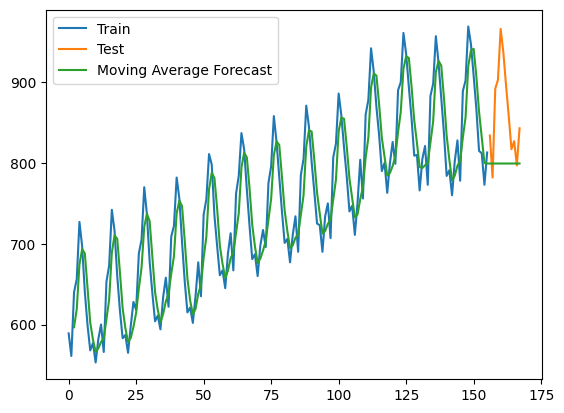

83.33766655400582


In [3]:
############## Trailing Rolling Mean #############################################
y_train = df['Milk'][:-12]
y_test = df['Milk'][-12:]
span=3
fcast = y_train.rolling(span).mean()
MA = fcast.iloc[-1]
MA_series = pd.Series(MA.repeat(len(y_test)))
MA_fcast = pd.concat([fcast,MA_series],ignore_index=True)
plt.plot(y_train,label='Train')
plt.plot(y_test, label='Test')
plt.plot(MA_fcast,label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()
rms=sqrt(mean_squared_error(y_test,MA_series))
print(rms)

{'smoothing_level': 0.8, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 589.0, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
77.89888756642048


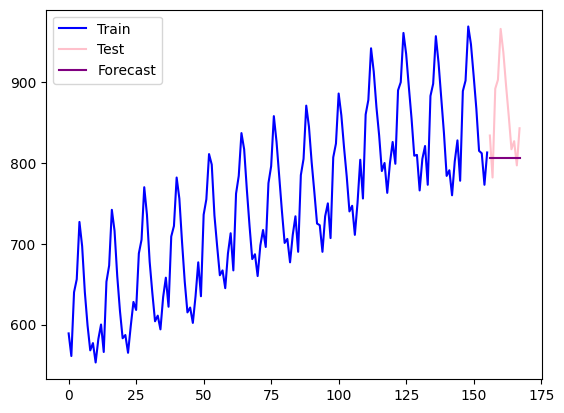

In [4]:
################################## Simple Exponential Smoothing ######################################################
filterwarnings('ignore')

alpha = 0.8
from statsmodels.tsa.api import SimpleExpSmoothing
ses = SimpleExpSmoothing(y_train)

fit1 = ses.fit(smoothing_level=alpha)
fcast1 = fit1.forecast(len(y_test))
print(fit1.params)
rms=sqrt(mean_squared_error(y_test,fcast1))
print(rms)  

#plot
y_train.plot(color='blue',label='Train')
y_test.plot(color='pink',label='Test')
fcast1.plot(color='purple',label='Forecast') #Graph on the last fcast1 value
plt.legend(loc='best')
plt.show()


In [5]:
############################################### Holt ##########################################################

gdp = pd.read_csv(r"D:\March 2024\PML\Day 14\gdp-per-capita-ppp-constant-2011.csv")
y_gdp = gdp['GDP per capita']
y_trn_gdp = gdp.drop('Year', axis=1).iloc[:-4]
print("y_trn_gdp \n",y_trn_gdp)
y_tst_gdp = gdp.drop('Year', axis=1).iloc[-4:]

print("y_tst_gdp \n",y_tst_gdp)

y_trn_gdp 
     GDP per capita
0         1754.857
1         1737.615
2         1796.532
3         1845.149
4         1930.113
5         2036.796
6         2149.366
7         2194.903
8         2288.048
9         2445.751
10        2495.047
11        2570.428
12        2623.330
13        2783.004
14        2955.205
15        3178.829
16        3419.931
17        3698.777
18        3786.633
19        4049.805
20        4404.697
21        4635.879
22        4827.560
23        5073.605
y_tst_gdp 
     GDP per capita
24        5385.142
25        5756.665
26        6095.723
27        6426.674


1093.5829668948418


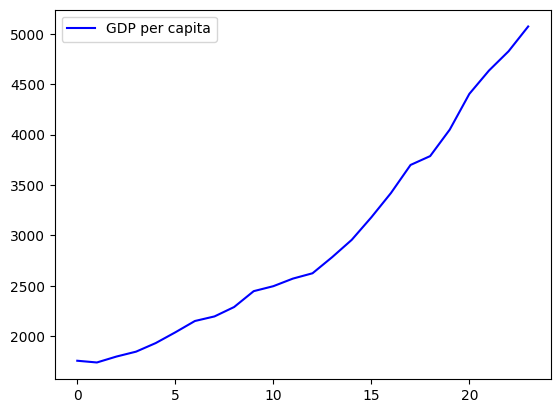

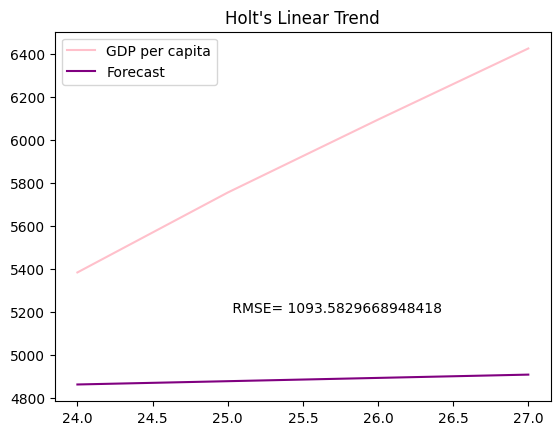

In [10]:
############################################### Holt's Linear Method ##########################################################
alpha = 0.5
beta = 0.01

from statsmodels.tsa.api import Holt
holt = Holt(y_trn_gdp)
fit1 = holt.fit(smoothing_level = alpha, smoothing_trend=beta)

fcast1 = fit1.forecast(len(y_tst_gdp))



#plot
y_trn_gdp.plot(color='blue',label='Train')
y_tst_gdp.plot(color='pink',label='Test')
fcast1.plot(color='purple',label='Forecast')
rms=sqrt(mean_squared_error(y_tst_gdp, fcast1))
print(rms)

plt.text(25,5200, " RMSE= "+str(rms))
plt.title("Holt's Linear Trend")
plt.legend(loc='best')
plt.show()

36.92599315526218


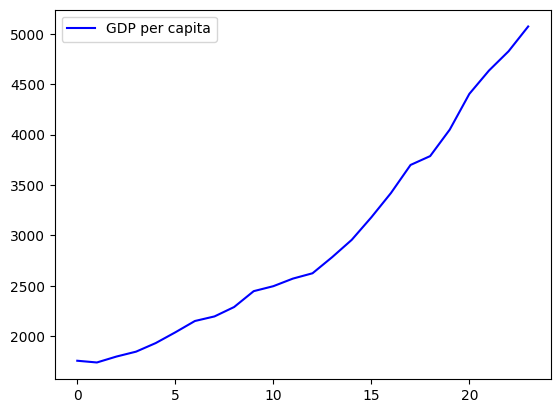

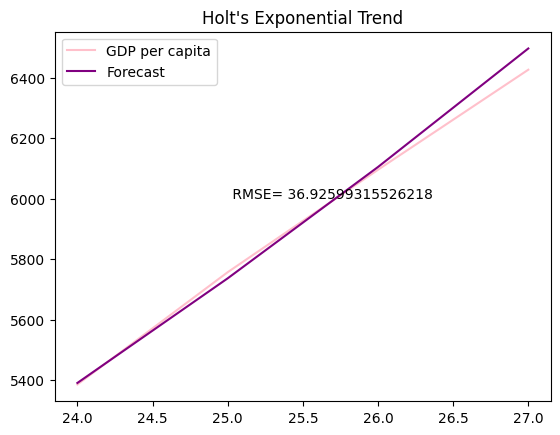

36.92599315526218


In [12]:
############################################### Holt's Exponential Method ##########################################################
alpha = 0.1
beta = 1

from statsmodels.tsa.api import Holt
holt = Holt(y_trn_gdp, exponential=True)
fit1 = holt.fit(smoothing_level = alpha, smoothing_trend=beta)

fcast1 = fit1.forecast(len(y_tst_gdp))

#plot
y_trn_gdp.plot(color='blue',label='Train')
y_tst_gdp.plot(color='pink',label='Test')
fcast1.plot(color='purple',label='Forecast')
rms=sqrt(mean_squared_error(y_tst_gdp, fcast1))
print(rms)

plt.text(25,6000, " RMSE= "+str(rms))
plt.title("Holt's Exponential Trend")
plt.legend(loc='best')
plt.show()

rms=sqrt(mean_squared_error(y_tst_gdp, fcast1))
print(rms)

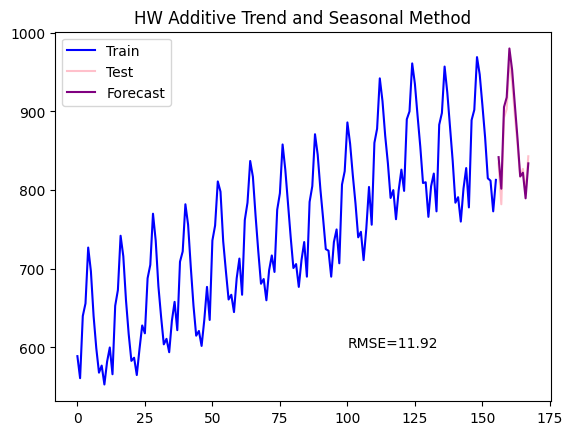

In [8]:
#It does not have Grid Search CV,
# but it can auto tune alpha , beta
# but it does GSCV on Train set but not on Test set.

# Damped Trend Methods

# Additive

from statsmodels.tsa.api import ExponentialSmoothing

alpha, beta, gamma = 0.8, 0.8, 0.8 #0.8, 0.02, 0.1
hw_add = ExponentialSmoothing(y_train, seasonal_periods=12, trend = 'add', seasonal='add')
fit1 = hw_add.fit() #without tuning RMSE = 11.92 #smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal=gamma
fcast1 = fit1.forecast(len(y_test))

#plot
y_train.plot(color = "blue", label = "Train")
y_test.plot(color = "pink", label = 'Test')
fcast1.plot(color = "purple", label ="Forecast")

error = round(sqrt(mean_squared_error(y_test, fcast1)),2)

plt.text(100,600, "RMSE="+str(error))
plt.title("HW Additive Trend and Seasonal Method")
plt.legend()
plt.show()

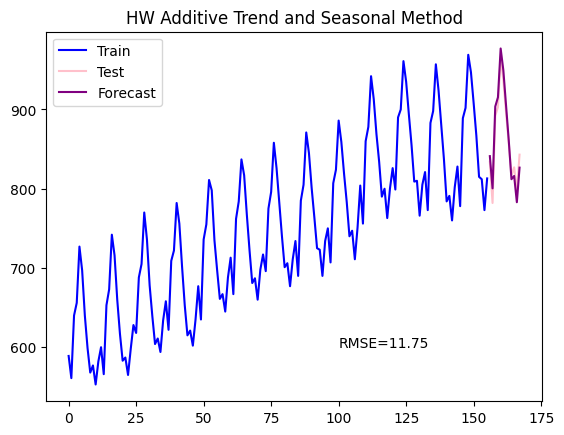

In [18]:
# Additive and damped

from statsmodels.tsa.api import ExponentialSmoothing

alpha, beta, gamma, phi = 0.8, 0.8, 0.8,0.1 #0.8, 0.02, 0.1
hw_add = ExponentialSmoothing(y_train, seasonal_periods=12, trend = 'add', seasonal='add', damped_trend=phi)
fit1 = hw_add.fit() #without tuning RMSE = 11.92 #smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal=gamma
fcast1 = fit1.forecast(len(y_test))

#plot
y_train.plot(color = "blue", label = "Train")
y_test.plot(color = "pink", label = 'Test')
fcast1.plot(color = "purple", label ="Forecast")

error = round(sqrt(mean_squared_error(y_test, fcast1)),2)

plt.text(100,600, "RMSE="+str(error))
plt.title("HW Additive Trend and Seasonal Method")
plt.legend()
plt.show()

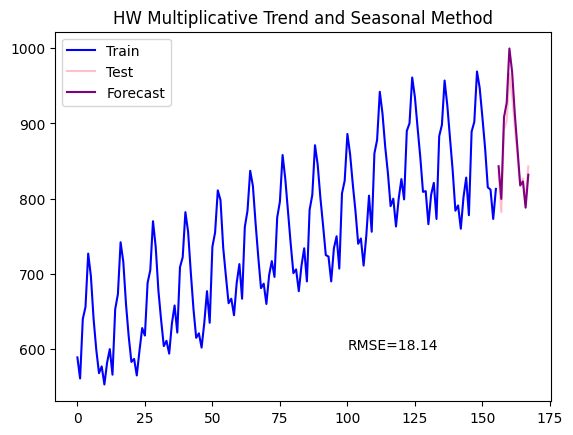

In [17]:
# Multiplicative

from statsmodels.tsa.api import ExponentialSmoothing

alpha, beta, gamma = 0.8, 0.8, 0.8 #0.8, 0.02, 0.1 #if tuned, it gives better values =>RMSE = 18.14
hw_mul = ExponentialSmoothing(y_train, seasonal_periods=12, trend = 'add', seasonal='mul') #added damping = True => RMSE = 17.1
fit1 = hw_mul.fit() #without tuning RMSE = 18.14 #smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal=gamma
fcast1 = fit1.forecast(len(y_test))

#plot
y_train.plot(color = "blue", label = "Train")
y_test.plot(color = "pink", label = 'Test')
fcast1.plot(color = "purple", label ="Forecast")

error = round(sqrt(mean_squared_error(y_test, fcast1)),2)

plt.text(100,600, "RMSE="+str(error))
plt.title("HW Multiplicative Trend and Seasonal Method")
plt.legend()
plt.show()

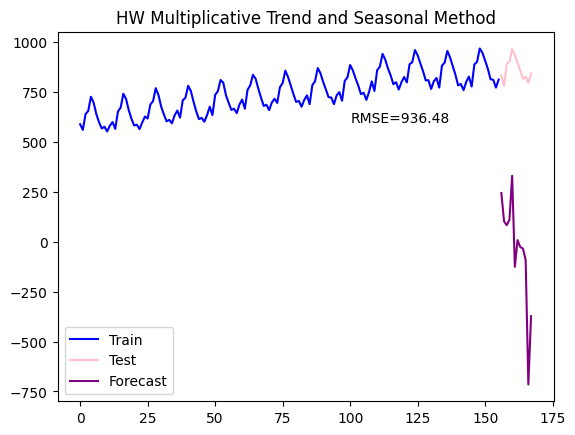

In [16]:

# Multiplicative and Damping

from statsmodels.tsa.api import ExponentialSmoothing

alpha, beta, gamma, phi = 0.8, 0.8, 0.8,0.1 #0.8, 0.02, 0.1 #if tuned, it gives better values =>RMSE = 18.14
hw_mul = ExponentialSmoothing(y_train, seasonal_periods=12, trend = 'add', seasonal='mul', damped_trend=phi) #added damping = True => RMSE = 17.1
fit1 = hw_mul.fit(smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal=gamma) #without tuning RMSE = 18.14 #smoothing_level = alpha, smoothing_trend = beta, smoothing_seasonal=gamma
fcast1 = fit1.forecast(len(y_test))

#plot
y_train.plot(color = "blue", label = "Train")
y_test.plot(color = "pink", label = 'Test')
fcast1.plot(color = "purple", label ="Forecast")

error = round(sqrt(mean_squared_error(y_test, fcast1)),2)

plt.text(100,600, "RMSE="+str(error))
plt.title("HW Multiplicative Trend and Seasonal Method")
plt.legend()
plt.show()